In [ ]:
import numpy as np
import numpy.random as npr
import math
import scipy
from scipy import special
from scipy import linalg

from tqdm import tqdm
from google.colab import files

%matplotlib inline
import matplotlib 
matplotlib.use('pdf')
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Histogram eigenvalues of each X'X
def histeig(eigs, ax, xgrid=None, dgrid=None, bins=100, xlim=None, ylim=None, title=None):
    if xlim is not None:
        eigs = eigs[np.nonzero(eigs <= xlim[1])[0]]
        h = ax.hist(eigs, bins=np.linspace(xlim[0], xlim[1], num=bins))
    else:
        h = ax.hist(eigs, bins=bins)
    if xgrid is not None:
        space = h[1][1] - h[1][0]
        ax.plot(xgrid, dgrid * len(eigs) * space, 'r', label='Prediction at initial', linewidth=2)
        ax.legend()
    ax.set_title(title, fontsize=12)
    ax.set_xlim(xlim)
    if ylim is None:
        ax.set_ylim([0, max(h[0]) * 1.5])
    else:
        ax.set_ylim(ylim)
    return ax

**Activation Functions**

In [ ]:
# relu
# b0 = 1/4
# b1 = 1/4
def relu(X,normalize=True):
    X[X<0] = 0
    if normalize:
        return np.sqrt(2*np.pi/(np.pi-1))*(X-1/np.sqrt(2*np.pi))
    else:
        return X

def relu_grad(X,normalize=True):
    X[X<0] = 0
    X[X>0] = 1
    if normalize:
        X[X>0] = np.sqrt(2*np.pi/(np.pi-1))
    return X

# softplus
# b0 = 1/4
# b1 = 0.043379
SP = torch.nn.Softplus()
def softplus(X,normalize=True):
    if normalize:
        c0 = 0.806059
        c1 = 0.271514
        return (SP(X)-c0) / (c1)**0.5
    else:
        return SP(X)

def softplus_grad(X,normalize=True):
    if normalize:
        c1 = 0.271514
        return torch.sigmoid(X) / (c1)**0.5
    else:
        return torch.sigmoid(X)

# sigmoid
# b0=0.042692
# b1 =0.002144 
def sigmoid(X,normalize=True):
    X = torch.sigmoid(X)
    if normalize:
        c = np.sqrt(0.21747 / (2 * np.sqrt(2 * np.pi)))
        return (X-0.5)/c
    else:
        return X

def sigmoid_grad(X,normalize=True):
    X = torch.sigmoid(X)
    if normalize:
        c = np.sqrt(0.21747 / (2 * np.sqrt(2 * np.pi)))
        return X * (1-X) / c
    else:
        return X * (1-X)

def tanh(X,normalize=True):
    X = torch.tanh(X)
    if normalize:
        c = 0.627928
        return X / c
    else:
        c = 1
        return X * c

def tanh_grad(X,normalize=True):
    X = torch.tanh(X)
    if normalize:
        c = 0.627928
        return (1 - X**2) / c
    else:
        c = 1
        return (1 - X**2) * c

def quadratic(X,normalize=True):
    if normalize:
        return (X**2-1) / np.sqrt(2)
    else:
        return X**2 / 2

def quadratic_grad(X,normalize=True):
    if normalize:
        return np.sqrt(2)*X
    else:
        return X

def linear(X):
    return X

def linear_grad(X):
    return X*0 + 1

# -----------------------------------------

def ortho_decomp(phi):
    if phi == relu:
        # relu
        c1 = 0.856429
        c2 = 0.341666
    elif phi == tanh:
        # tanh
        c1 = 0.96461
        c2 = 0
    elif phi == quadratic:
        # Quadratic
        c1 = 1e-10
        c2 = 0.5
    elif phi == softplus:
        c1 = 0.959564
        c2 = 0.198266
    else:
        # Linear
        c1 = 1
        c2 = 0
    return c1, c2

# Student Model

**Two-layer Neural Network:** 

$f(\mathbf{x}) = \sum_{i=1}^h a_i\phi(\langle \mathbf{x},\mathbf{w}_i\rangle)$. $\mathbf{w}_i\in\mathbb{R}^d$. 

\\
**Initialization:** 

- $w_{ij} \sim \mathcal{N}(0,d^{-2\alpha_1})$.

- $a_i \sim \mathcal{N}(0,h^{-2\alpha_2})$. 

**Note:** 

- $\alpha_2=1  \Rightarrow$  mean-field regime.
- $\alpha_1=\alpha_2=1/2  \Rightarrow$  kernel regime.

**Current Setting:** $\alpha_1 = 1/2, \alpha_2 = 1/2$. 

\\

# Proportional limit

- Let $n$ be the number of training sample size.
-  $\gamma_1:=\lim d/n\in (0,\infty)$ as $n\to \infty$.
- $\gamma_2:=\lim h/n\in (0,\infty)$ as $n\to \infty$.

\\

# Gradient Update

- $a_{t+1} = a_t - \eta\nabla_a L(f)$.
- $w_{t+1} = w_t - \eta\nabla_w L(f)$.



In [ ]:
# activation function
act = relu
grad = relu_grad

# parameterization
mean_field = False

# scaling of parameters
alpha1 = 0.5

if mean_field:
    alpha2 = 1
else:
    alpha2 = 0.5

train_2nd = True
# Don't need to do the doubling trick for the mean-field parameterization
doubling = True

**Multiple-index Target Function on Unit Gaussian Input**. 

+ $\mathbf{x}\sim\mathcal{N}(0,\mathbf{I}_d)$.
+ $y = \phi(\langle\mathbf{x},\mathbf{\theta}_*\rangle)$. Parameter \mathbf{\theta}_*$ is known in this teacher model.


In [ ]:
def unit_Gaussian(n,d):
    return torch.FloatTensor(n,d).normal_(mean=0,std=1).to(device) 
 

def single_index(n,d,n1,sigma=0.1,nonlin=relu):
    X = unit_Gaussian(n,d)
    X_test = unit_Gaussian(n1,d)
    theta = torch.FloatTensor(d,1).normal_(mean=0,std=1).to(device)  
    theta = theta / torch.norm(theta)
    if sigma == 0:
        return X, nonlin(X@theta), X_test, nonlin(X_test@theta)
    else:
        return X, nonlin(X@theta) + torch.FloatTensor(n,1).normal_(mean=0,std=sigma).to(device), X_test, nonlin(X_test@theta)

def multi_index(n,d,n1,sigma=0.1,ind=1,nonlin=relu):
    X = unit_Gaussian(n,d)
    X_test = unit_Gaussian(n1,d)
    theta = torch.FloatTensor(d,ind).normal_(mean=0,std=1).to(device) 
    theta = theta / torch.norm(theta)
    a = torch.ones([ind,1]).to(device) / (ind**0.5)
    Y = nonlin(X@theta)@a
    Y_test = nonlim(X_test@theta)@a
    if sigma == 0:
        return X, Y, X_test, Y_test
    else:
        return X, Y + torch.FloatTensor(n,1).normal_(mean=0,std=sigma).to(device), X_test, Y_test



In [ ]:
# classification or single-index
classification = False

SNR = 12
# std of Gaussian
sigma = (1/SNR)**0.5
# sparsity of target function
spar = 1

print("SNR: %f" % (SNR))
print("noise: %f" % (sigma))

SNR: 12.000000
noise: 0.288675


In [ ]:
# Y1 - true labels
# Y2 - model prediction

def mse(Y1,Y2):
    return torch.mean((Y1-Y2)**2)

def logistic(Y1,Y2):
    return torch.mean(SP(-Y1*Y2))

def mse_grad(Y1,Y2):
    return Y1 - Y2

def logistic_grad(Y1,Y2):
    return Y1 * torch.sigmoid(-Y1 * Y2)


# ------------------------------------
# Choose objective

loss_fn = mse
loss_grad = mse_grad

In [ ]:
gamma1 = 0.2 # gamma1 = d/n
gamma2 = 2 # gamma2 = h/n

# whether both layers are optimized
train_2nd = True
# Don't need to do the doubling trick for the mean-field parameterization
doubling = True

# L2 regularization
lda = 0
# Learning rate
eta = 0.03
# Max step size
n_max = 2500
# Number of steps
steps = 500

# --------------------------------------------

inc= 200
n_list = np.arange(400,n_max,inc)

NN_loss = np.zeros([len(n_list),2])
NN_weight_diff = np.zeros([len(n_list),4])

for i in tqdm(range(len(n_list))):
    print(i)
    n = n_list[i]
    print(n)
    d = int(n*gamma1)
    h = int(n*gamma2)
    X,Y,X_test,Y_test = multi_index(n,d,int(n/2),sigma=sigma,ind=1,nonlin=sigmoid)
    # doubling trick
    if doubling == True:
        W_half = torch.FloatTensor(d,h//2).normal_(mean=0,std=(1/d)**alpha1).to(device)
        W = torch.cat([W_half,W_half],dim=1)
    else:
        W = torch.FloatTensor(d,h).normal_(mean=0,std=(1/d)**alpha1).to(device)

    # Gaussian 2nd layer
    if doubling == True:
        b_half = torch.FloatTensor(h//2,1).normal_(mean=0,std=(1/h)**alpha2).to(device)
        b = torch.cat([b_half,-b_half])
    else:
        b = torch.FloatTensor(h,1).normal_(mean=0,std=(1/h)**alpha2).to(device)

    # Rademacher 2nd layer
    b = (torch.cat([torch.ones(h//2, 1),-torch.ones(h//2,1)])/(h**(alpha2))).to(device)
    W_temp = W * (b**0).flatten()
    _,s0,_ = torch.svd(W_temp@torch.t(W_temp))
    Ws = W.clone()
    bs = b.clone()
    XX = X@torch.t(X) / d
    CK0 = act(X@W)@torch.t(act(X@W)) / h
    eta_w = eta
    eta_b = eta
    XW_grad0 = grad(X@W)
    S0 = XW_grad0*((torch.ones(n, 1).to(device))@torch.t(b))
    RF0 = S0@torch.t(S0)
    NTK0 = XX * RF0
    if train_2nd:
        NTK0 = NTK0 + CK0
    for j in tqdm(range(steps)):

        ys = act(X@Ws)@bs

        # update parameters
        dW = torch.t(X) @ (loss_grad(Y, ys) @ torch.t(bs) * grad(X@Ws)) / n
        Ws = Ws + eta_w * (dW - lda*Ws)

        if train_2nd:
            db = torch.t(X@Ws)@loss_grad(Y, ys) / n
            bs = bs + eta_b * (db - lda*bs)

    XW = act(X@Ws)
    y_NN = act(X_test@Ws)@bs
    NN_loss[i-1,0] = loss_fn(ys,Y)
    NN_loss[i-1,1] = loss_fn(y_NN,Y_test)
    _,s1,_ = torch.svd(Ws@torch.t(Ws))
    NN_weight_diff[i,0] = torch.abs(s1[0]-s0[0])
    NN_weight_diff[i,1] = torch.linalg.norm(Ws-W, ord=2)
    # CK model
    CK1 = act(X@Ws)@torch.t(act(X@Ws)) / h
    NN_weight_diff[i,2] = torch.linalg.norm(CK1-CK0, ord=2)
    # NTK model
    XW_grad = grad(X@Ws)
    S = XW_grad*((torch.ones(n, 1).to(device))@torch.t(bs))
    RFs = S@torch.t(S)
    NTKs = XX * RFs
    if train_2nd:
        NTKs = NTKs + CK1
    NN_weight_diff[i,3] = torch.linalg.norm(NTKs-NTK0, ord=2)

    print("-------------------------------------------------")
    print("dimesion: %d; Training Loss: %f" % (n,loss_fn(ys,Y)))


  0%|          | 0/11 [00:00<?, ?it/s]

0
400



  9%|▉         | 46/500 [00:00<00:00, 454.76it/s]

-------------------------------------------------
dimesion: 400; Training Loss: 0.001637
1
600



  6%|▌         | 29/500 [00:00<00:01, 288.08it/s]

-------------------------------------------------
dimesion: 600; Training Loss: 0.001609
2
800



  4%|▍         | 19/500 [00:00<00:02, 186.77it/s]

-------------------------------------------------
dimesion: 800; Training Loss: 0.001319
3
1000



  3%|▎         | 14/500 [00:00<00:03, 130.78it/s]

-------------------------------------------------
dimesion: 1000; Training Loss: 0.001275
4
1200



  2%|▏         | 11/500 [00:00<00:04, 100.20it/s]

-------------------------------------------------
dimesion: 1200; Training Loss: 0.001275
5
1400



  2%|▏         | 8/500 [00:00<00:06, 78.04it/s]

-------------------------------------------------
dimesion: 1400; Training Loss: 0.001160
6
1600



  0%|          | 0/500 [00:00<?, ?it/s]

-------------------------------------------------
dimesion: 1600; Training Loss: 0.001118
7
1800



  0%|          | 0/500 [00:00<?, ?it/s]

-------------------------------------------------
dimesion: 1800; Training Loss: 0.001127
8
2000



  0%|          | 0/500 [00:00<?, ?it/s]

-------------------------------------------------
dimesion: 2000; Training Loss: 0.001088
9
2200



  0%|          | 0/500 [00:00<?, ?it/s]

-------------------------------------------------
dimesion: 2200; Training Loss: 0.001045
10
2400



100%|██████████| 11/11 [01:46<00:00,  9.68s/it]

-------------------------------------------------
dimesion: 2400; Training Loss: 0.001061


<Figure size 432x288 with 0 Axes>

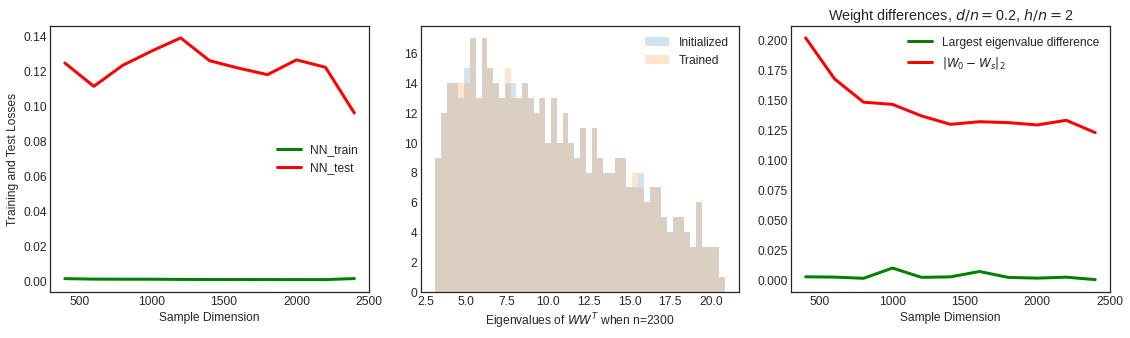

In [ ]:
plt.figure(0)
FONT_SIZE = 12
plt.rc('font',size=FONT_SIZE)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,5))
bin = 50

ax1.plot(n_list,NN_loss[:,0],color='g',linewidth=3,label='NN_train')
ax1.plot(n_list,NN_loss[:,1],color='r',linewidth=3,label='NN_test')
ax1.set_xlabel('Sample Dimension')
ax1.set_ylabel('Training and Test Losses')
ax3.title.set_text('Losses $d/n=$%f'% gamma1)
ax1.legend()

#histeig(s0.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s1.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax2.hist(s0.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax2.hist(s1.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax2.set_xlabel('Eigenvalues of $WW^T$ when n=%d'% n_fin)
ax2.legend()

ax3.plot(n_list,NN_weight_diff[:,0],color='g',linewidth=3,label='Largest eigenvalue difference')
ax3.plot(n_list,NN_weight_diff[:,1],color='r',linewidth=3,label='$\|W_0-W_s\|_2$')
ax3.set_xlabel('Sample Dimension')
ax3.title.set_text('Weight differences, $d/n=$%g, $h/n=$%g'% (gamma1,gamma2))
ax3.legend()

fig.tight_layout(pad=1.5)

In [ ]:
# spectrum of NTK and CK
_,s2,_ = torch.svd(CK0)
_,s3,_ = torch.svd(CK1)
_,s4,_ = torch.svd(NTK0)
_,s5,_ = torch.svd(NTKs)

<Figure size 432x288 with 0 Axes>

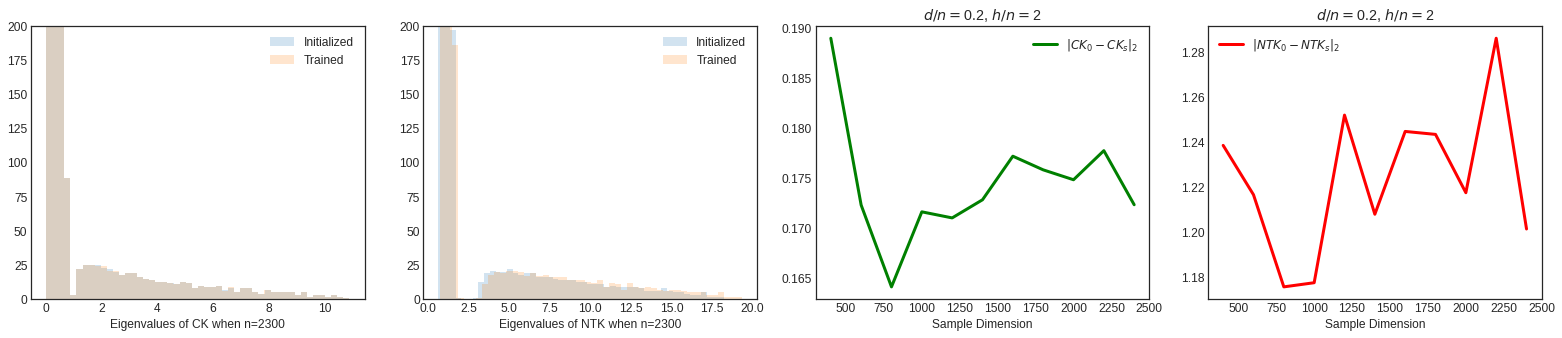

In [ ]:
plt.figure(0)
FONT_SIZE = 12
plt.rc('font',size=FONT_SIZE)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(22,5))
bin = 50

#histeig(s2.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s3.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax1.hist(s2.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax1.hist(s3.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax1.set_ylim([0,75])
ax1.set_xlabel('Eigenvalues of CK when n=%d'% n_fin)
ax1.legend()

#histeig(s4.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s5.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax2.hist(s4.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax2.hist(s5.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax2.set_ylim([0,75])
ax2.set_xlabel('Eigenvalues of NTK when n=%d'% n_fin)
ax2.legend()

ax3.plot(n_list,NN_weight_diff[:,2],color='g',linewidth=3,label='$\|CK_0-CK_s\|_2$')
ax3.set_xlabel('Sample Dimension')
ax3.title.set_text('$d/n=$%g, $h/n=$%g'% (gamma1,gamma2))
ax3.legend()


ax4.plot(n_list,NN_weight_diff[:,3],color='r',linewidth=3,label='$\|NTK_0-NTK_s\|_2$')
ax4.set_xlabel('Sample Dimension')
ax4.title.set_text('$d/n=$%g, $h/n=$%g'% (gamma1,gamma2))
ax4.legend()

fig.tight_layout(pad=1.5)

In [ ]:
gamma1 = 0.2 # gamma1 = d/n
gamma2 = 2 # gamma2 = h/n

# whether both layers are optimized
train_2nd = True
# Don't need to do the doubling trick for the mean-field parameterization
doubling = True

# L2 regularization
lda = 0
# Learning rate
eta = 0.03
# Max step size
n_max = 7600
# Number of steps
steps = 500

# --------------------------------------------

inc= 500
n_list = np.arange(2500,n_max,inc)

NN_loss = np.zeros([len(n_list),2])
NN_weight_diff = np.zeros([len(n_list),4])

for i in tqdm(range(len(n_list))):
    print(i)
    n = n_list[i]
    print(n)
    d = int(n*gamma1)
    h = int(n*gamma2)
    X,Y,X_test,Y_test = multi_index(n,d,int(n/2),sigma=sigma,ind=1,nonlin=sigmoid)
    # doubling trick
    if doubling == True:
        W_half = torch.FloatTensor(d,h//2).normal_(mean=0,std=(1/d)**alpha1).to(device)
        W = torch.cat([W_half,W_half],dim=1)
    else:
        W = torch.FloatTensor(d,h).normal_(mean=0,std=(1/d)**alpha1).to(device)

    # Gaussian 2nd layer
    if doubling == True:
        b_half = torch.FloatTensor(h//2,1).normal_(mean=0,std=(1/h)**alpha2).to(device)
        b = torch.cat([b_half,-b_half])
    else:
        b = torch.FloatTensor(h,1).normal_(mean=0,std=(1/h)**alpha2).to(device)

    # Rademacher 2nd layer
    b = (torch.cat([torch.ones(h//2, 1),-torch.ones(h//2,1)])/(h**(alpha2))).to(device)
    W_temp = W * (b**0).flatten()
    _,s0,_ = torch.svd(W_temp@torch.t(W_temp))
    Ws = W.clone()
    bs = b.clone()
    XX = X@torch.t(X) / d
    CK0 = act(X@W)@torch.t(act(X@W)) / h
    eta_w = eta
    eta_b = eta
    XW_grad0 = grad(X@W)
    S0 = XW_grad0*((torch.ones(n, 1).to(device))@torch.t(b))
    RF0 = S0@torch.t(S0)
    NTK0 = XX * RF0
    if train_2nd:
        NTK0 = NTK0 + CK0
    for j in tqdm(range(steps)):

        ys = act(X@Ws)@bs

        # update parameters
        dW = torch.t(X) @ (loss_grad(Y, ys) @ torch.t(bs) * grad(X@Ws)) / n
        Ws = Ws + eta_w * (dW - lda*Ws)

        if train_2nd:
            db = torch.t(X@Ws)@loss_grad(Y, ys) / n
            bs = bs + eta_b * (db - lda*bs)

    XW = act(X@Ws)
    y_NN = act(X_test@Ws)@bs
    NN_loss[i-1,0] = loss_fn(ys,Y)
    NN_loss[i-1,1] = loss_fn(y_NN,Y_test)
    _,s1,_ = torch.svd(Ws@torch.t(Ws))
    NN_weight_diff[i,0] = torch.abs(s1[0]-s0[0])
    NN_weight_diff[i,1] = torch.linalg.norm(Ws-W, ord=2)
    # CK model
    CK1 = act(X@Ws)@torch.t(act(X@Ws)) / h
    NN_weight_diff[i,2] = torch.linalg.norm(CK1-CK0, ord=2)
    # NTK model
    XW_grad = grad(X@Ws)
    S = XW_grad*((torch.ones(n, 1).to(device))@torch.t(bs))
    RFs = S@torch.t(S)
    NTKs = XX * RFs
    if train_2nd:
        NTKs = NTKs + CK1
    NN_weight_diff[i,3] = torch.linalg.norm(NTKs-NTK0, ord=2)

    print("-------------------------------------------------")
    print("dimesion: %d; Training Loss: %f" % (n,loss_fn(ys,Y)))


  0%|          | 0/11 [00:00<?, ?it/s]

0
2500



  9%|▉         | 1/11 [00:30<05:04, 30.46s/it]

-------------------------------------------------
dimesion: 2500; Training Loss: 0.001103
1
3000



 18%|█▊        | 2/11 [01:16<05:16, 35.17s/it]

-------------------------------------------------
dimesion: 3000; Training Loss: 0.001042
2
3500



 27%|██▋       | 3/11 [02:29<06:12, 46.58s/it]

-------------------------------------------------
dimesion: 3500; Training Loss: 0.001029
3
4000



 36%|███▋      | 4/11 [04:05<07:08, 61.19s/it]

-------------------------------------------------
dimesion: 4000; Training Loss: 0.000976
4
4500



 45%|████▌     | 5/11 [06:28<08:35, 85.86s/it]

-------------------------------------------------
dimesion: 4500; Training Loss: 0.000973
5
5000



 55%|█████▍    | 6/11 [09:31<09:34, 114.92s/it]

-------------------------------------------------
dimesion: 5000; Training Loss: 0.000965
6
5500



 64%|██████▎   | 7/11 [13:43<10:24, 156.14s/it]

-------------------------------------------------
dimesion: 5500; Training Loss: 0.000954
7
6000



 73%|███████▎  | 8/11 [18:41<09:55, 198.67s/it]

-------------------------------------------------
dimesion: 6000; Training Loss: 0.000966
8
6500



 82%|████████▏ | 9/11 [25:22<08:38, 259.36s/it]

-------------------------------------------------
dimesion: 6500; Training Loss: 0.000958
9
7000



 91%|█████████ | 10/11 [33:09<05:21, 321.67s/it]

-------------------------------------------------
dimesion: 7000; Training Loss: 0.000971
10
7500



100%|██████████| 11/11 [43:18<00:00, 236.19s/it]

-------------------------------------------------
dimesion: 7500; Training Loss: 0.000955


<Figure size 432x288 with 0 Axes>

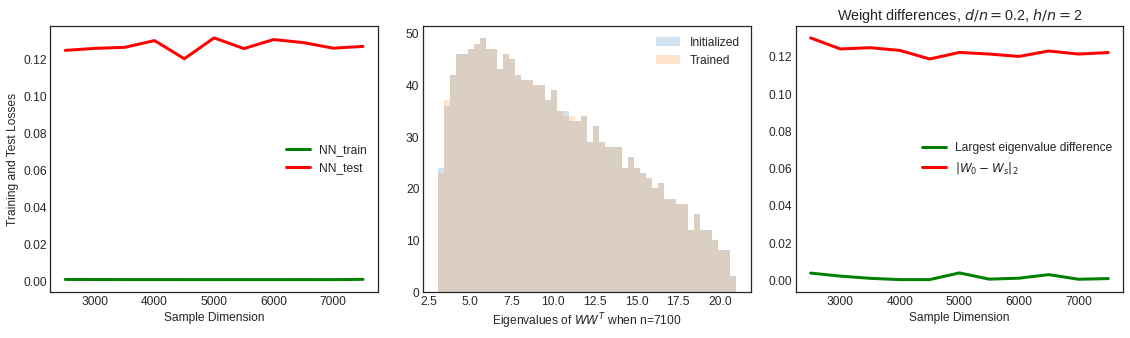

In [ ]:
plt.figure(0)
FONT_SIZE = 12
plt.rc('font',size=FONT_SIZE)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,5))
bin = 50

ax1.plot(n_list,NN_loss[:,0],color='g',linewidth=3,label='NN_train')
ax1.plot(n_list,NN_loss[:,1],color='r',linewidth=3,label='NN_test')
ax1.set_xlabel('Sample Dimension')
ax1.set_ylabel('Training and Test Losses')
ax3.title.set_text('Losses $d/n=$%f'% gamma1)
ax1.legend()

#histeig(s0.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s1.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax2.hist(s0.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax2.hist(s1.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax2.set_xlabel('Eigenvalues of $WW^T$ when n=%d'% n_fin)
ax2.legend()

ax3.plot(n_list,NN_weight_diff[:,0],color='g',linewidth=3,label='Largest eigenvalue difference')
ax3.plot(n_list,NN_weight_diff[:,1],color='r',linewidth=3,label='$\|W_0-W_s\|_2$')
ax3.set_xlabel('Sample Dimension')
ax3.title.set_text('Weight differences, $d/n=$%g, $h/n=$%g'% (gamma1,gamma2))
ax3.legend()

fig.tight_layout(pad=1.5)

In [ ]:
# spectrum of NTK and CK
_,s2,_ = torch.svd(CK0)
_,s3,_ = torch.svd(CK1)
_,s4,_ = torch.svd(NTK0)
_,s5,_ = torch.svd(NTKs)

<Figure size 432x288 with 0 Axes>

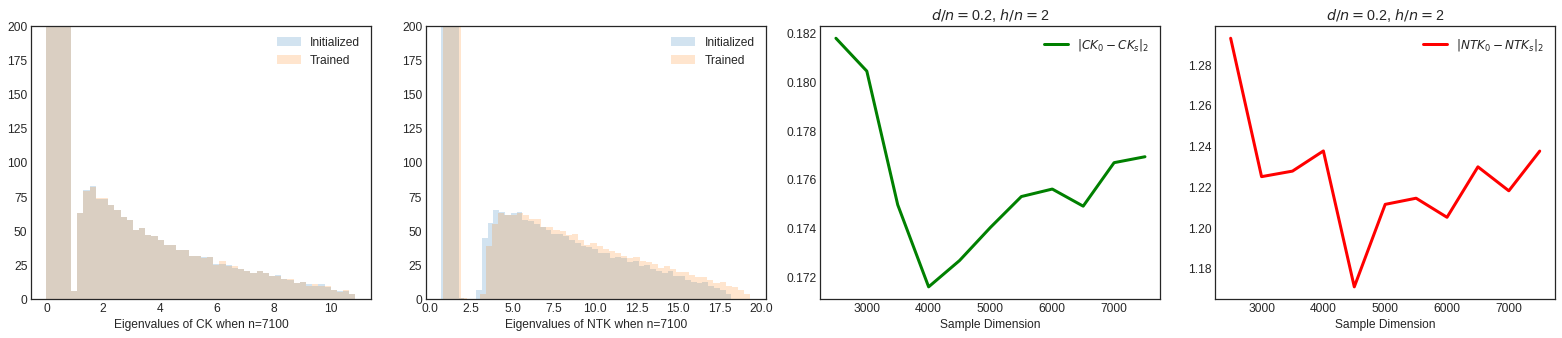

In [ ]:
plt.figure(0)
FONT_SIZE = 12
plt.rc('font',size=FONT_SIZE)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(22,5))
bin = 50

#histeig(s2.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s3.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax1.hist(s2.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax1.hist(s3.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax1.set_ylim([0,200])
ax1.set_xlabel('Eigenvalues of CK when n=%d'% n_fin)
ax1.legend()

#histeig(s4.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s5.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax2.hist(s4.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax2.hist(s5.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax2.set_ylim([0,200])
ax2.set_xlabel('Eigenvalues of NTK when n=%d'% n_fin)
ax2.legend()

ax3.plot(n_list,NN_weight_diff[:,2],color='g',linewidth=3,label='$\|CK_0-CK_s\|_2$')
ax3.set_xlabel('Sample Dimension')
ax3.title.set_text('$d/n=$%g, $h/n=$%g'% (gamma1,gamma2))
ax3.legend()


ax4.plot(n_list,NN_weight_diff[:,3],color='r',linewidth=3,label='$\|NTK_0-NTK_s\|_2$')
ax4.set_xlabel('Sample Dimension')
ax4.title.set_text('$d/n=$%g, $h/n=$%g'% (gamma1,gamma2))
ax4.legend()

fig.tight_layout(pad=1.5)